# Classifying reviews with RNNs

## Data Summary

This [dataset of yelp reviews](https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews) contains 560,000 highly positive or negative yelp reviews for training, and 38,000 for testing.  
The original data was constructed and analyzed by *Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015)*

Due to the size of the dataset - I'm working with a smaller sample of 40,000 review here, training on 30,000 and testing on 10,000 (50:50 split for positive and negative).  

Label 1 = positive  
Label 0 = negative  

## Analysis Objectives

In this analysis, I am going to compare variations in recurrent neural network models to try to accurately classify the sentiment of yelp reviews.

The model variations are:  
* Simple RNN  
* Simple RNN with dropout  
* LSTM model  

In [1]:
# basics
import pandas as pd
import numpy as np
from random import randint

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

%matplotlib inline

# set to show vector images
set_matplotlib_formats('pdf', 'svg')

## Data Overview

In [2]:
# load in the data:
import tensorflow_datasets as tfds
data, info = tfds.load('yelp_polarity_reviews',
                 split='train', with_info=True,
                 as_supervised=True)

In [3]:
# convert to pandas -- and let's work with a subset for ease/time
yelp_df = tfds.as_dataframe(data.take(50000), info)
yelp_df.shape

(50000, 2)

In [4]:
yelp_df.head(5)

,label,text
0,1,"b""The Groovy P. and I ventured to his old stom..."
1,0,"b""Mediocre burgers - if you are in the area an..."
2,0,b'Not at all impressed...our server was not ve...
3,0,"b""I wish I would have read Megan P's review be..."
4,1,b'A large selection of food from all over the ...


Re-format data to get an equal number of postive and negative reviews (20,000 each):

In [5]:
yelp_df.groupby('label').count()

,text
label,
0,24963
1,25037


In [6]:
pos = yelp_df[yelp_df.label == 1].sample(20000)
neg = yelp_df[yelp_df.label == 0].sample(20000)
yelp_df = pos.append(neg).reset_index(drop=True)

In [7]:
yelp_df.groupby('label').count()

,text
label,
0,20000
1,20000


Before I analyse the data, I'm going to clean it up a bit, removing characters like line breaks, etc.:

In [8]:
def clean_text(text):
    cleaned = text.decode("utf-8")
    cleaned = cleaned.replace("\\n", " ")
    cleaned = cleaned.replace("\'", "'")
    cleaned = cleaned.replace("\\r", " ")
    cleaned = cleaned.replace("\\""", " ")
    return cleaned

In [9]:
# apply cleaning to text
for i in range(yelp_df.shape[0]):
    yelp_df.loc[i,'text'] = clean_text(yelp_df.loc[i,'text'])

Let's take a look at an example positive review:

In [10]:
print('Example positive review:\n\n',yelp_df[yelp_df.label == 1].text.tolist()[randint(1,20000)],'\n')

Example positive review:

 We were looking for a family cooking style place after 9pm & uptown games had let out. On the way home, saw this place and pulled in. Staff was incredibly friendly & super fast food. We will def be back! Great low key down home cookin kind of spot. Tons on the menu. Super casual 



In [11]:
print('Example negative review:\n\n',yelp_df[yelp_df.label == 0].text.tolist()[randint(1,20000)],'\n')

Example negative review:

 Went again. Wanted to be seated at a table in the bar to watch sports. We arrived at 5:00 pm. Every table in the bar was empty and reserved for a trivia tournament of some sorts. They refused to let us sit in the bar. The staff was not helpful at all and so we left. Very disappointed. 



Now, I'm plotting the length of all positive and negative yelp reviews in case this is very different:

In [12]:
# number of characters in each string
yelp_df['length'] = yelp_df.text.str.len()
yelp_df.head()

,label,text,length
0,1,GREAT rooms with all the amenities you could e...,387
1,1,Woohooooo!! Writing this review makes me want ...,777
2,1,"This place is really unique, in a good way. Th...",405
3,1,4.5 stars Bobby flay really knows how to use ...,634
4,1,Yelp comes thru again......... The prawn/octo...,947


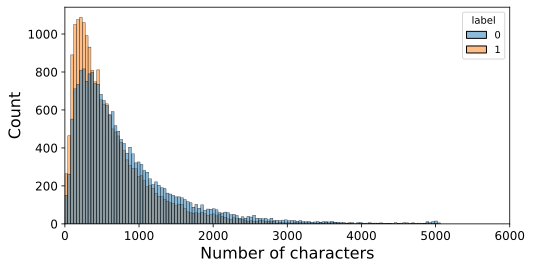

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(data=yelp_df, x='length', hue='label')
plt.xlim([0,6000])
plt.xticks(fontsize=12)
plt.xlabel('Number of characters', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('Count', fontsize=16)
plt.show()

In [14]:
yelp_df.groupby('label').mean()

,length
label,
0,813.1110
1,632.2376


The positive reviews tend to be a bit shorter than the negative reviews, so it might be worth investigating if this influences or biases model performance in the future.

Finally, before I build the models, I need to tokenize the text (turn it into integer sequences, with padding):

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(yelp_df.text)

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100  # maximum length of a sequence - truncate after this
sequences = tokenizer.texts_to_sequences(yelp_df.text)

padded_sequences = pad_sequences(sequences, maxlen, padding = 'post')
labels = yelp_df.label

## Model comparison

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras import initializers

Divide data into equal train and test splits:

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.25, 
                                          random_state=10)

# get indices
train_idx, test_idx = next(strat_shuff_split.split(padded_sequences, labels))

# Create the train and test data
X_train, X_test = padded_sequences[train_idx], padded_sequences[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

Check that it's balanced:

In [19]:
print('Train data:\n', y_train.value_counts(normalize=True),'\n')
print('Test data:\n', y_test.value_counts(normalize=True),'\n')

Train data:
 1    0.5
0    0.5
Name: label, dtype: float64 

Test data:
 1    0.5
0    0.5
Name: label, dtype: float64 



In [20]:
X_train.shape

(30000, 100)

In [21]:
X_test.shape

(10000, 100)

### A) Simple RNN

In [22]:
rnn_hidden_dim = 10
word_embedding_dim = 64

model_A = Sequential()
# add embedding later -- takes each integer in the sequence and embeds it in a X-dimensional vector
model_A.add(Embedding(max_features, word_embedding_dim, input_length=maxlen))  

# use simple RNN with default params, apart from activation = ReLU
model_A.add(SimpleRNN(rnn_hidden_dim, 
                      kernel_initializer=initializers.RandomNormal(stddev=0.001),
                      recurrent_initializer=initializers.Identity(gain=1.0),
                      activation='relu'))

# add dense layer
model_A.add(Dense(1, activation='sigmoid'))

In [23]:
model_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                750       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,280,761
Trainable params: 1,280,761
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_A.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model_A.fit(X_train, y_train,
            epochs=5,
            validation_data=(X_test, y_test))

Epoch 1/5
938/938 [==============================] - 23s 24ms/step - loss: 0.4969 - accuracy: 0.7622 - val_loss: 0.2807 - val_accuracy: 0.8875
Epoch 2/5
938/938 [==============================] - 22s 24ms/step - loss: 0.1954 - accuracy: 0.9260 - val_loss: 0.2478 - val_accuracy: 0.9036
Epoch 3/5
938/938 [==============================] - 22s 24ms/step - loss: 0.1362 - accuracy: 0.9490 - val_loss: 0.3025 - val_accuracy: 0.8949
Epoch 4/5
938/938 [==============================] - 21s 23ms/step - loss: 0.1052 - accuracy: 0.9622 - val_loss: 0.2817 - val_accuracy: 0.8953
Epoch 5/5
938/938 [==============================] - 21s 22ms/step - loss: 0.0838 - accuracy: 0.9705 - val_loss: 0.3917 - val_accuracy: 0.8865


So the simplest RNN does a pretty good job but may be overfitting the training data, with the validation loss going back up in the final epoch.

### B) Simple RNN: dropout

To try to reduce overfitting, I'm now adding in a dropout parameter of 0.5 and reducing the hidden dimension to 5.

In [26]:
rnn_hidden_dim = 5
word_embedding_dim = 64

model_B = Sequential()
# add embedding later -- takes each integer in the sequence and embeds it in a X-dimensional vector
model_B.add(Embedding(max_features, word_embedding_dim, input_length=maxlen))  

# use simple RNN with default params, apart from activation = ReLU
model_B.add(SimpleRNN(rnn_hidden_dim, 
                      dropout = 0.5,
                      kernel_initializer=initializers.RandomNormal(stddev=0.001),
                      recurrent_initializer=initializers.Identity(gain=1.0),
                      activation='relu'))

# add dense layer
model_B.add(Dense(1, activation='sigmoid'))

In [27]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           1280000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5)                 350       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,280,356
Trainable params: 1,280,356
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_B.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model_B.fit(X_train, y_train,
            epochs=5,
            validation_data=(X_test, y_test))

Epoch 1/5
938/938 [==============================] - 26s 27ms/step - loss: 0.4511 - accuracy: 0.7668 - val_loss: 0.2505 - val_accuracy: 0.9009
Epoch 2/5
938/938 [==============================] - 26s 28ms/step - loss: 0.2170 - accuracy: 0.9174 - val_loss: 0.2475 - val_accuracy: 0.9053
Epoch 3/5
938/938 [==============================] - 25s 27ms/step - loss: 0.1814 - accuracy: 0.9359 - val_loss: 0.2530 - val_accuracy: 0.9008
Epoch 4/5
938/938 [==============================] - 25s 27ms/step - loss: 0.1446 - accuracy: 0.9473 - val_loss: 0.2710 - val_accuracy: 0.8962
Epoch 5/5
938/938 [==============================] - 26s 28ms/step - loss: 0.1324 - accuracy: 0.9516 - val_loss: 0.3204 - val_accuracy: 0.8910


These changes seem to have improved the model slightly, in that it doesn't appear to be overfitting as much, the validation loss is lower and the validation accuracy is marginally higher.

### C) LSTM

Finally, let's try a LSTM model instead with a bidirectional layer.

In [30]:
rnn_hidden_dim = 10
word_embedding_dim = 64

model_C = Sequential()
# add embedding later -- takes each integer in the sequence and embeds it in a X-dimensional vector
model_C.add(Embedding(max_features, word_embedding_dim, input_length=maxlen)) 

# Bi-directional LSTM
model_C.add(Bidirectional(LSTM(units=rnn_hidden_dim)))

# add dense layer
model_C.add(Dense(1, activation='sigmoid'))

In [31]:
model_C.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 64)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                6000      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,286,021
Trainable params: 1,286,021
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_C.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model_C.fit(X_train, y_train,
            epochs=5,
            validation_data=(X_test, y_test))

Epoch 1/5
938/938 [==============================] - 37s 37ms/step - loss: 0.4565 - accuracy: 0.7750 - val_loss: 0.2577 - val_accuracy: 0.9003
Epoch 2/5
938/938 [==============================] - 33s 35ms/step - loss: 0.1866 - accuracy: 0.9345 - val_loss: 0.2509 - val_accuracy: 0.9002
Epoch 3/5
938/938 [==============================] - 33s 35ms/step - loss: 0.1168 - accuracy: 0.9608 - val_loss: 0.2675 - val_accuracy: 0.9009
Epoch 4/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0820 - accuracy: 0.9715 - val_loss: 0.3080 - val_accuracy: 0.8989
Epoch 5/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0539 - accuracy: 0.9834 - val_loss: 0.3672 - val_accuracy: 0.8960


The LSTM model again seems to improve things very slightly over and above a simple RNN. All models do reasonably well with a final accuracy of just under 0.9.

## Key Findings

The above models all performed relatively similarly, with the LSTM marginally winning in terms of validation accuracy. The Simple RNN shows signs of overfitting the data, which is improved by adding drop out in Model B. I think I would recommend exploring the LSTM model further, but with extra steps to prevent overfitting and, hopefully, improve validation accuracy further. 

## Limitations and Future modifications

There are a number of ways in which these models could be improved. First, I did not make any changes to the features and length of the sequences generated from the review text. It is possible that changing the maximum length could improve the model generalisability. Second, a large number of parameters could be altered when constructing the models, including the hidden dimension, number of layers, etc. Third, I could train on a larger subset of the data to improve model perforance. Finally, I noticed that the positive reviews tend to be shorter than the negative reviews, so it might be worth investigating if this influences or biases model performance in the future, although setting a max length to the sequences might control for this difference.